In [30]:
# General libs
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
!pip install opencv-python
import cv2
import os

# ML libs
!pip install keras
!pip install tensorflow
import keras.backend as K
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dropout, Dense, BatchNormalization
from keras.layers import LeakyReLU, PReLU, Activation, Conv2D, SeparableConv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History, EarlyStopping
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy  # Import CategoricalCrossentropy

tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

True


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
input_path = '/content/drive/MyDrive/chest_xray/'

counter_normal_train = len(os.listdir(input_path + 'train' + '/NORMAL'))
counter_infect_train = len(os.listdir(input_path + 'train' + '/PNEUMONIA'))

counter_normal_test = len(os.listdir(input_path + 'test' + '/NORMAL'))
counter_infect_test = len(os.listdir(input_path + 'test' +  '/PNEUMONIA'))

counter_normal_val = len(os.listdir(input_path + 'val' + '/NORMAL'))
counter_infect_val = len(os.listdir(input_path + 'val' +  '/PNEUMONIA'))

counter_all = counter_normal_train + counter_infect_train + counter_normal_test + counter_infect_test + counter_normal_val +  counter_infect_val
counter_all_healthy = counter_normal_train + counter_normal_test + counter_normal_val
counter_all_infect = counter_infect_train + counter_infect_test + counter_infect_val

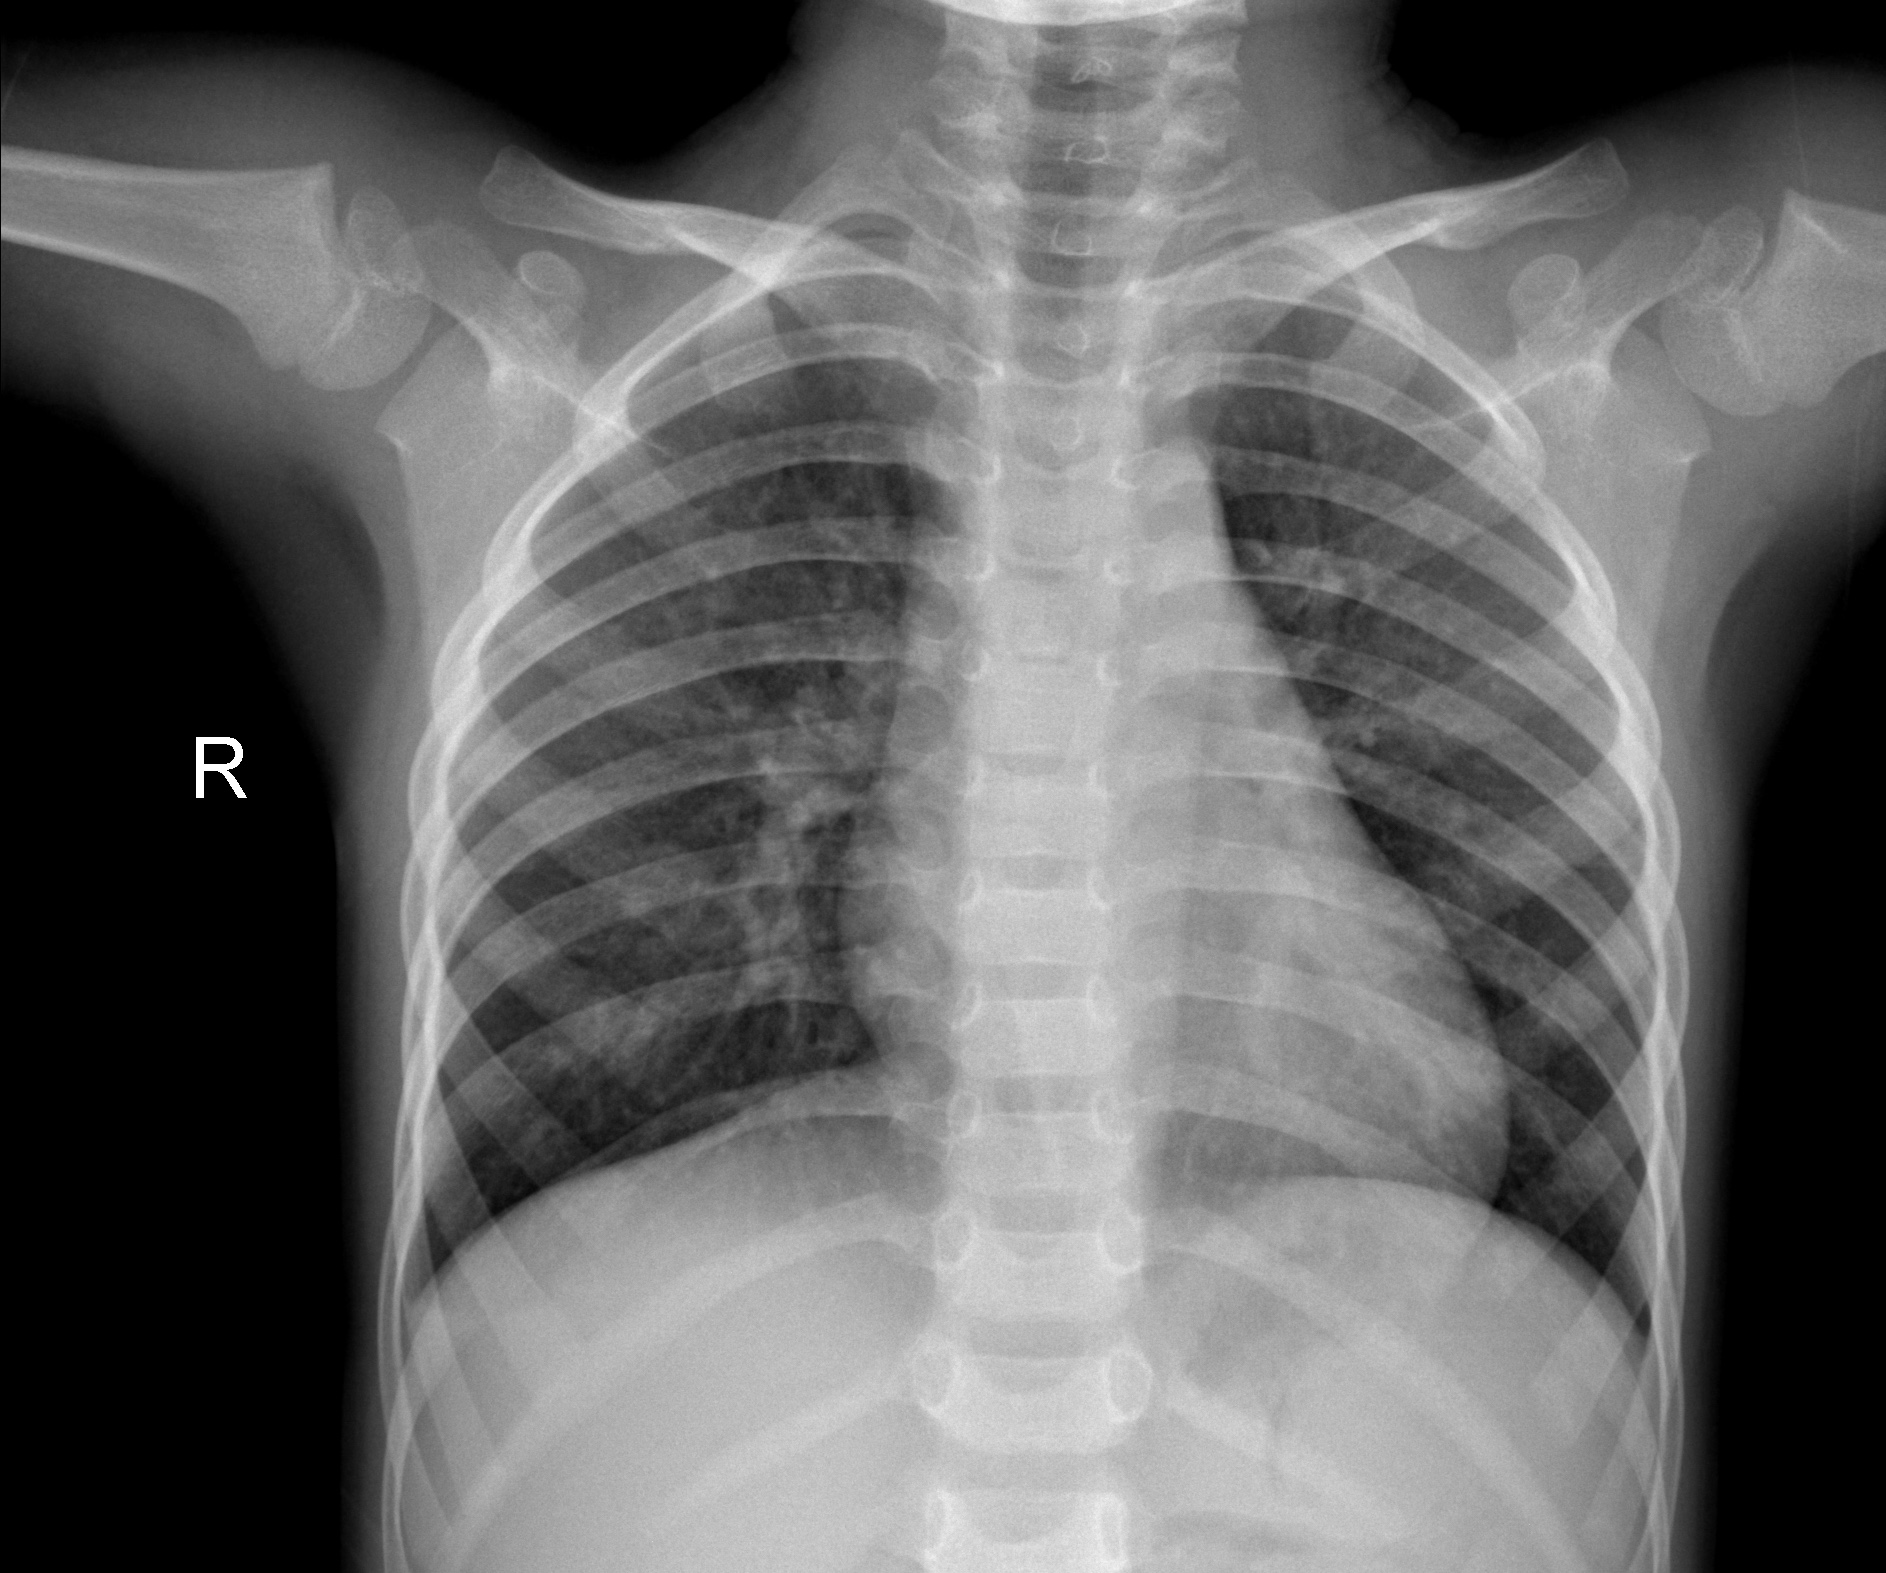

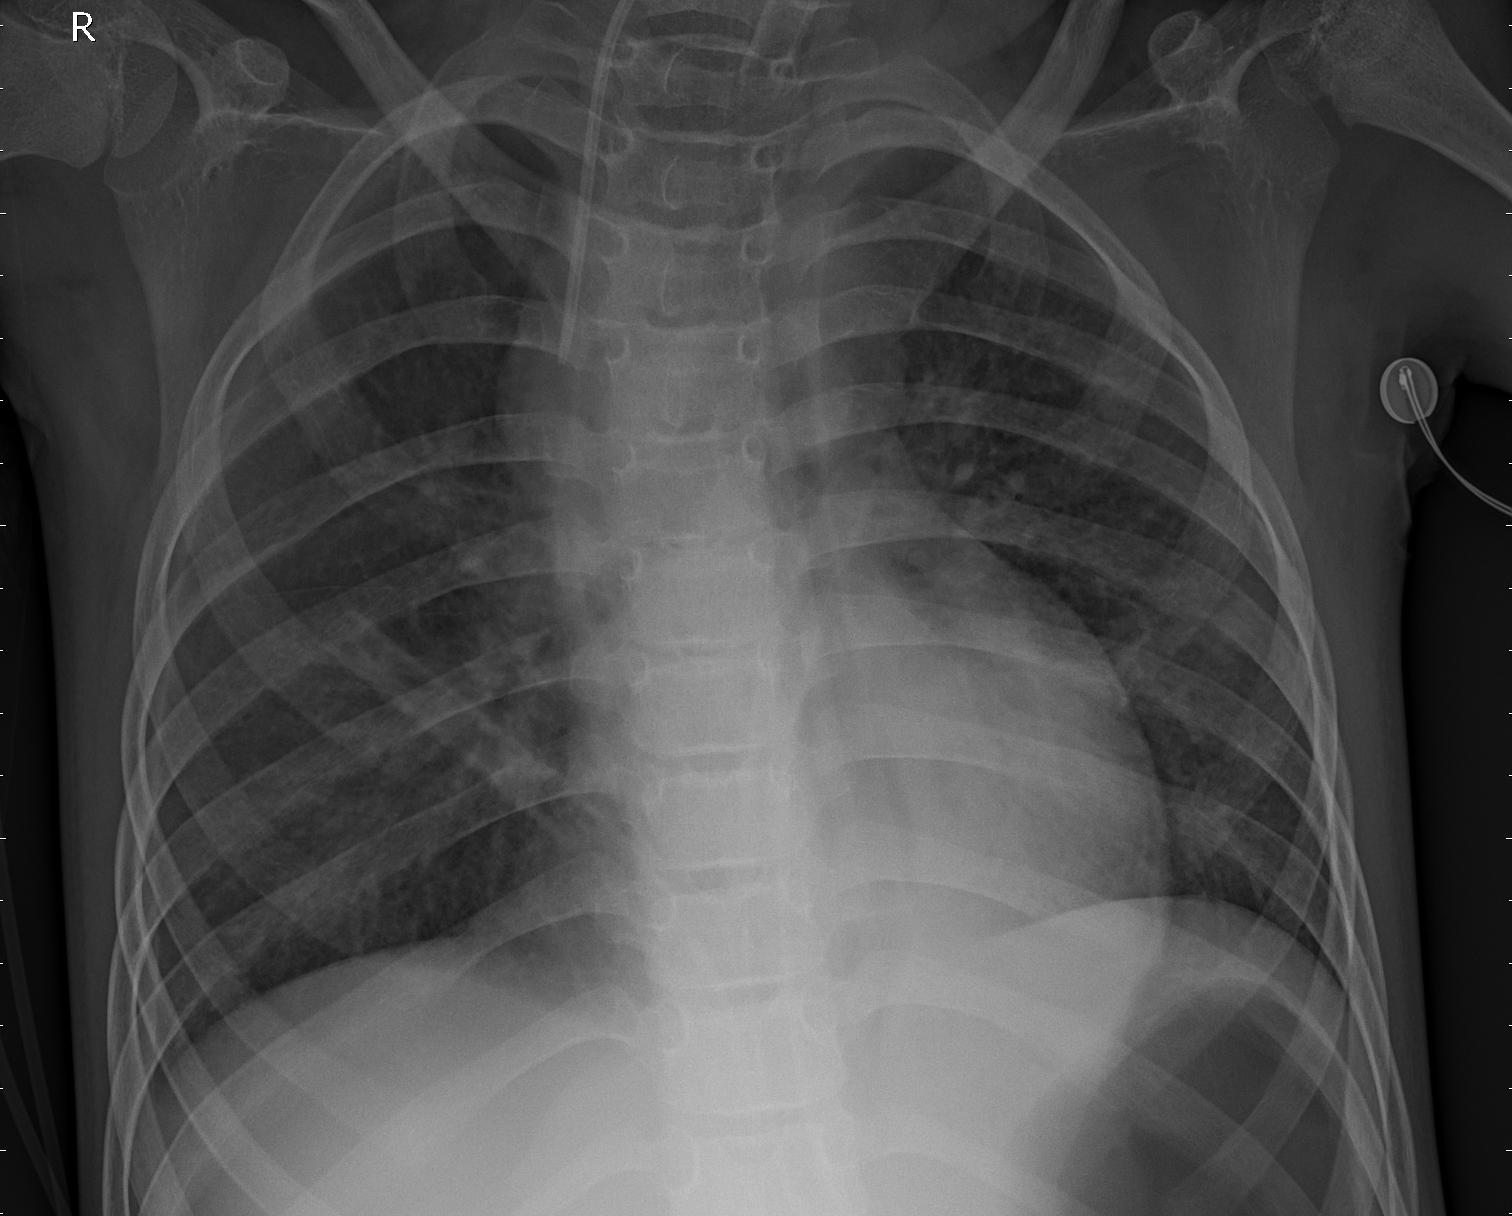

In [42]:
import os
import random
from IPython.display import Image, display


# Define the path to your sample location
location1 = "/content/drive/MyDrive/chest_xray/train/NORMAL"
location2 = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"

# List all the image files in the directory
image_files1 = [f for f in os.listdir(location1) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
image_files2 = [f for f in os.listdir(location2) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]


if not image_files1 or not image_files2:
    print("No image files found in one or both of the specified locations.")
else:
    # Choose a random image from each location
    random_image_path1 = os.path.join(location1, random.choice(image_files1))
    random_image_path2 = os.path.join(location2, random.choice(image_files2))

    # Open and display the first random image
    image1 = Image(random_image_path1)
    display(image1)

    # Open and display the first random image
    image2 = Image(random_image_path2)
    display(image2)


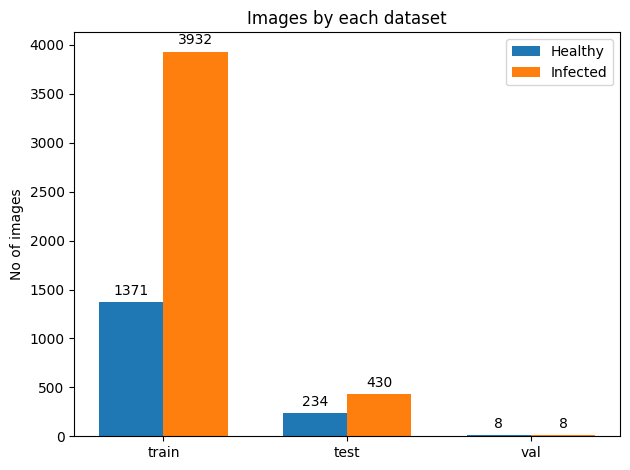

In [43]:
labels = ['train', 'test', 'val']
healthy_means = [counter_normal_train, counter_normal_test, counter_normal_val]
infected_means = [counter_infect_train, counter_infect_test, counter_infect_val]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, healthy_means, width, label='Healthy')
rects2 = ax.bar(x + width/2, infected_means, width, label='Infected')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No of images')
ax.set_title('Images by each dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

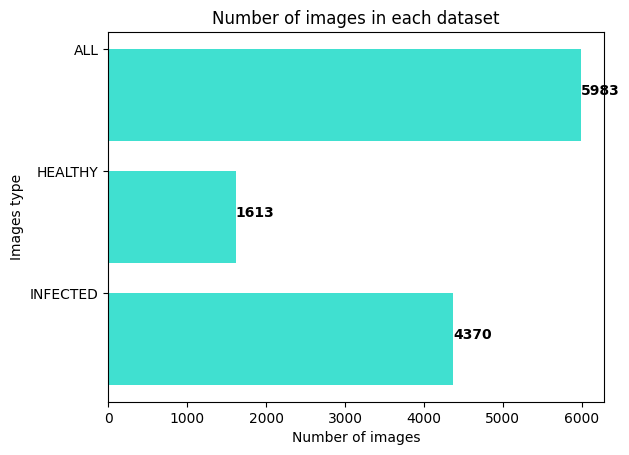

In [44]:
x = [u'INFECTED', u'HEALTHY', u'ALL']
y = [counter_all_infect, counter_all_healthy, counter_all]

fig, ax = plt.subplots()
width = 0.75 # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="turquoise")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Number of images in each dataset')
plt.xlabel('Number of images')
plt.ylabel('Images type')
#plt.show()
plt.savefig(os.path.join('pneumonia_class.png'), dpi=400, format='png', bbox_inches='tight')
# use format='svg' or 'pdf' for vectorial pictures

for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

In [45]:
def process_images(dimensions, batch):
  train_datagen =    ImageDataGenerator(rescale = 1./255,
                                        zca_whitening=False,
                                        horizontal_flip = False,
                                        zoom_range = 0.5,
                                        vertical_flip = True)
  test_val_datagen = ImageDataGenerator (rescale= 1./255)

  train_gen = train_datagen.flow_from_directory(directory = input_path + 'train',
                                                target_size = (dimensions, dimensions),
                                                batch_size = batch,
                                                class_mode = 'binary',
                                                shuffle = True)

  val_gen = test_val_datagen.flow_from_directory(directory = input_path + 'val',
                                                target_size = (dimensions, dimensions),
                                                batch_size = batch,
                                                class_mode = 'binary',
                                                shuffle = True)
  test_gen = test_val_datagen.flow_from_directory(directory = input_path + 'test',
                                                  target_size = (dimensions, dimensions),
                                                  batch_size = batch,
                                                  class_mode = 'binary',
                                                  shuffle = True)

  test_data = []
  test_labels = []

  for condition in ['/NORMAL/', '/PNEUMONIA/']:
    for image in (os.listdir(input_path + 'test' + condition)):
      image = plt.imread(input_path + 'test' + condition + image)
      image = cv2.resize(image, (dimensions, dimensions))
      image = np.dstack([image, image, image])
      image = image.astype('float32') / 255
      if condition == '/NORMAL/':
        label = 0
      elif condition == '/PNEUMONIA/':
        label = 1

      test_data.append(image)
      test_labels.append(label)

  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  return train_gen, val_gen, test_gen, test_data, test_labels


In [46]:
dimensions = 150
epochs = 11
batch = 16

train_gen, val_gen, test_gen, test_data, test_labels = process_images(dimensions, batch)

Found 5303 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 664 images belonging to 2 classes.


In [49]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same', input_shape=(150,150,3)))
model.add(Conv2D(16, kernel_size=(3, 3), padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

#model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Creating a model and compiling
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])

# Output layer for multi-class classification
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Creating a model and compiling
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

# Callbacks
#tensor_board = TensorBoard(log_dir='graph.metrics',
#                                           histogram_freq=0,
#                                           write_graph=True,
#                                           write_images=True)
checkpoint = ModelCheckpoint(filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose = 1,
                             mode = 'auto',
                             save_best_only=True,
                             save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              verbose=1)
history = History()

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=3) #zca whitening and early stopping, change

In [55]:
hist = model.fit_generator(train_gen,
                           steps_per_epoch = train_gen.samples // batch,
                           epochs = epochs,
                           validation_data = test_gen,
                           validation_steps = test_gen.samples // batch,
                           callbacks = [checkpoint, lr_reduce])
model.save("originalmodel_originaldataset.h5")

<ipython-input-55-914aee3b7ec2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_gen,


Epoch 1/11
331/331 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9397
Epoch 1: val_loss did not improve from 0.34915
331/331 [==============================] - 498s 2s/step - loss: 0.2041 - accuracy: 0.9397 - val_loss: 0.3573 - val_accuracy: 0.8948 - lr: 8.1000e-06
Epoch 2/11
331/331 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9399
Epoch 2: val_loss improved from 0.34915 to 0.33823, saving model to weights.02-0.34.hdf5
331/331 [==============================] - 483s 1s/step - loss: 0.1984 - accuracy: 0.9399 - val_loss: 0.3382 - val_accuracy: 0.8979 - lr: 8.1000e-06
Epoch 3/11
331/331 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9476
Epoch 3: val_loss improved from 0.33823 to 0.33411, saving model to weights.03-0.33.hdf5
331/331 [==============================] - 476s 1s/step - loss: 0.1924 - accuracy: 0.9476 - val_loss: 0.3341 - val_accuracy: 0.8994 - lr: 8.1000e-06
Epoch 4/11
331/331 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


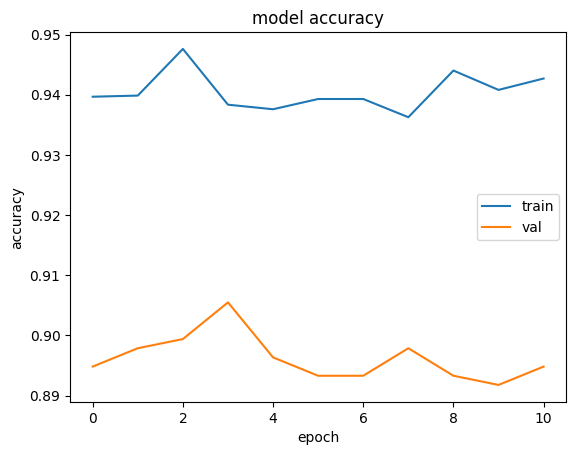

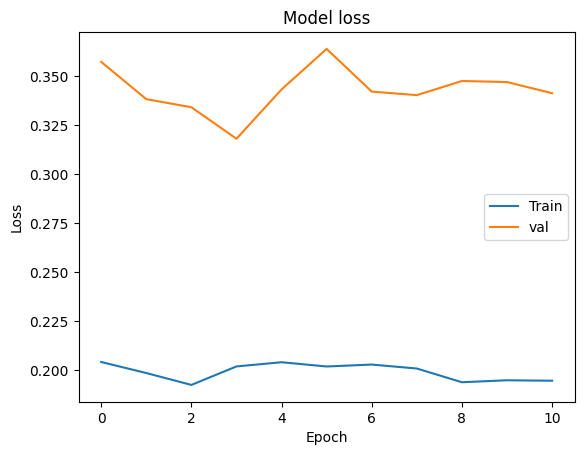

In [57]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'])
plt.show()

In [58]:
predict_probs = model.predict(test_data)
#predict_classes = model.predict_classes(test_data, verbose=0)
print(predict_probs)

# Calculate predicted classes using the predicted probabilities (assuming a threshold of 0.5)
predict_classes = np.round(predict_probs)
predict_classes = np.array(predict_classes).reshape(test_labels.shape).astype(int)

print("Test labels", test_labels)
print("Predict classes", predict_classes)


print ('\nTest metrics\n----------------')
cm = confusion_matrix(test_labels, predict_classes)
print ('Confusion matrix\n', cm)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, predict_classes) * 100
print('Accuracy: {}%'.format(np.round(accuracy,2)))
# precision tp / (tp + fp)
precision = precision_score(test_labels, predict_classes) * 100
print('Precision: {}%'.format(np.round(precision,2)))
# recall: tp / (tp + fn)
recall = recall_score(test_labels, predict_classes) * 100
print('Recall: {}%'.format(np.round(recall,2)))
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, predict_classes) * 100
print('F1-score: {}%'.format(np.round(2* precision * recall / (precision + recall),2)))

auc = roc_auc_score(test_labels, predict_probs)
print('ROC AUC: %f' % auc)

print('\nTrain metric\n----------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

21/21 [==============================] - 15s 697ms/step
[[0.06552136]
 [0.04809214]
 [0.12467059]
 [0.07902864]
 [0.09413662]
 [0.15255299]
 [0.1320911 ]
 [0.01592723]
 [0.12784947]
 [0.08871555]
 [0.0597213 ]
 [0.11776283]
 [0.04523802]
 [0.0839117 ]
 [0.04907053]
 [0.03122753]
 [0.91770864]
 [0.12198956]
 [0.9552815 ]
 [0.13415879]
 [0.05745997]
 [0.09546153]
 [0.02636713]
 [0.11077119]
 [0.05054667]
 [0.22198714]
 [0.1275035 ]
 [0.12481848]
 [0.09283929]
 [0.1090895 ]
 [0.13849512]
 [0.12534016]
 [0.17458485]
 [0.10846042]
 [0.09118627]
 [0.6929885 ]
 [0.07788574]
 [0.05854493]
 [0.27729034]
 [0.07612043]
 [0.03787775]
 [0.02349872]
 [0.04979958]
 [0.60537857]
 [0.05630714]
 [0.995479  ]
 [0.07406995]
 [0.10328896]
 [0.09700722]
 [0.03050699]
 [0.05369644]
 [0.02847461]
 [0.03107321]
 [0.25402004]
 [0.13871832]
 [0.02368066]
 [0.04958274]
 [0.0624426 ]
 [0.32143408]
 [0.94353944]
 [0.03489979]
 [0.9729176 ]
 [0.24582627]
 [0.05821056]
 [0.06946746]
 [0.0191303 ]
 [0.03406179]
 [0.02